Самойлов Александр Павлович

In [ ]:
!pip install ffmpeg-python

In [ ]:
# Импортируем необходимые библиотеки
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import random



1. загружает речевой файл (любой из интернета, только чистая речь без фона). Ограничьтесь 5 секундами речи.

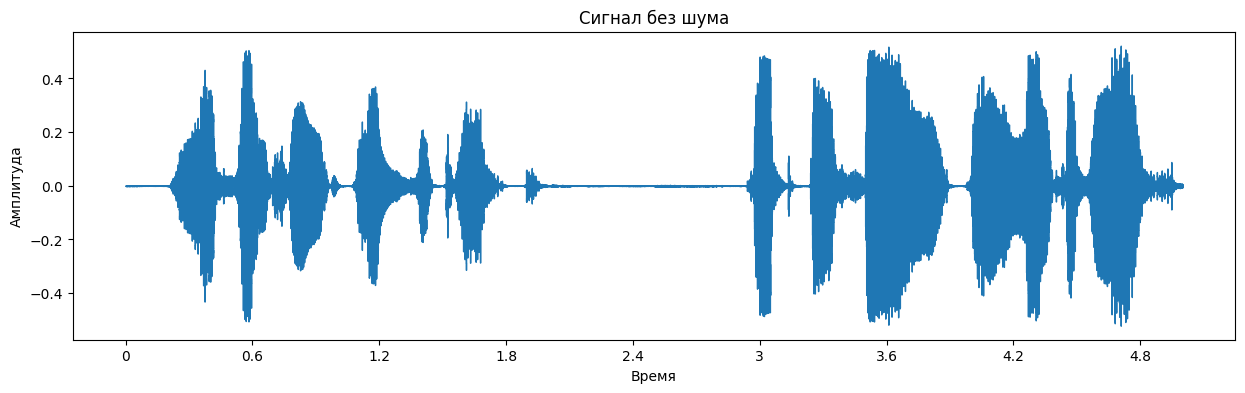

In [ ]:
audio_path = librosa.example('libri2')  # пример из библиотеки librosa, возьмем второй он поприкольнее
speech, sr = librosa.load(audio_path,
                        duration=5)  # Ограничиваем 5 секундами речи
plt.figure(figsize=(15,4))
librosa.display.waveshow(speech,
                         sr = sr) # рисуем сигнал
plt.title("Сигнал без шума") # устанавливаем title
plt.xlabel("Время") # подпись по OX
plt.ylabel("Амплитуда") # подпись по OY
ipd.Audio(speech,
          rate=sr)  # Прослушивание исходного сигнала

2. Наложите на него помеху в виде синусоидального сигнала, у которой частота увеличивается со временем, а амплитуда изменяется по косинусоидальному закону. На время звучания речи должно приходиться два периода изменения амплитуды, частота увеличивается в два раза. Начальная частота помехи равна 1\10 от частоты дискретизации сигнала речи

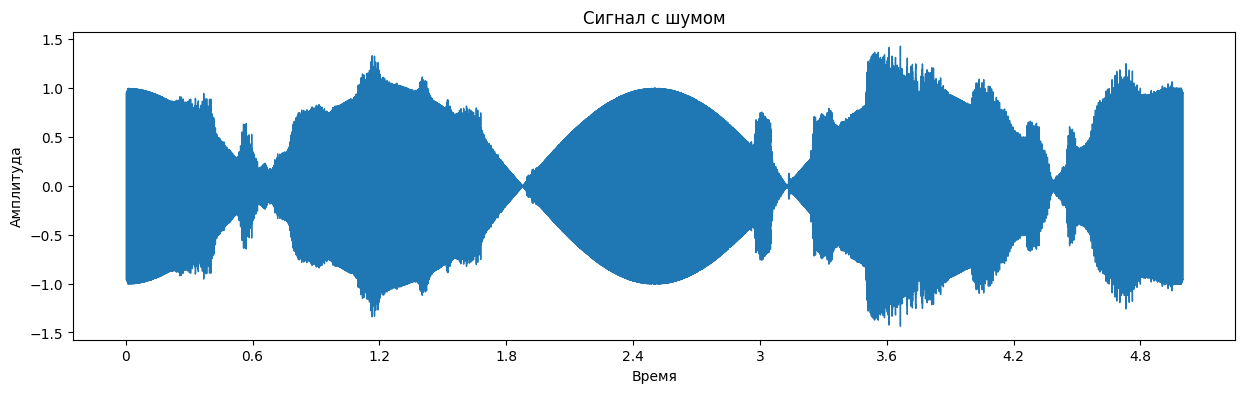

In [ ]:
t = np.linspace(0, len(speech) / sr, len(speech)) # разбиваем наш временной отрезок на временные участки
w0 = sr / 10  # Начальная частота помехи
w_noise = w0 * (1 + t / t[-1])  # Частота, увеличивающаяся во времени от 1 до 2
a_noise = np.cos(2 * np.pi * 2 * t / t[-1])  # Амплитуда меняется по косинусоидальному закону
noise = a_noise * np.sin(2 * np.pi * w_noise * t) # Шум меняется по синусоидальному закону
noisy_signal = speech +  noise # Зашумленный сигнал

plt.figure(figsize=(15,4)) # Размер полотна
librosa.display.waveshow(noisy_signal,
                         sr = sr) # рисуем сигнал
plt.title("Сигнал с шумом") # Устанавливаем title
plt.xlabel("Время") # Подписывае OX
plt.ylabel("Амплитуда") # Подписывае OY
ipd.Audio(noisy_signal,
          rate=sr)  # Прослушивание зашумленного сигнала

3. Реализуйте нормализованный LMS фильтр самостоятельно, без использования библиотек (кроме numpy).

In [ ]:
class NormalizedLMSFilter:
    def __init__(self, lr=0.1, filter_len=20): # Конструктор
        self.lr = lr  # Скорость обучения
        self.filter_len = filter_len  # Количество парамтеров
        self.w = np.zeros(filter_len)  # Инициализация весов фильтра

    def predict(self, x): # Метод предикт
        return np.dot(self.w, x)  # Скалярное произведение матрицы весов на матрицу объектов. Выход фильтра.

    def fit(self, x, d): # Функция подбора весов, fit
        y = self.predict(x)  # Выход фильтра
        e = d - y  # Ошибка между ожидаемым и предсказанным
        norm = np.dot(x, x)  # Нормализация
        if norm > 0: # чтобы не поделить на 0 случайно
            self.w += self.lr * e * x / norm  # Обновление весов
        return e # Возвращаем ошибку

4. Примените такой фильтр для помехоподавления в схеме адаптивного линейного предсказателя (как на семинаре). Подберите гиперпараметры фильтра для лучшей работы.

In [ ]:
# Функция применения NLMS фильтра
def run(speech, noisy_signal, filter_len=10, lr=0.1):
    nlms_filter = NormalizedLMSFilter(lr, filter_len) # создаем фильтр
    filtered_signal = np.zeros_like(noisy_signal) # инициализируем сигнал той же размерности, что и защумленный

    for i in range(filter_len, len(noisy_signal)): # Для выполнения фильтрации требуется как минимум выборка filter_len
        x = noisy_signal[i-filter_len:i]  # Входные данные
        filtered_signal[i] = nlms_filter.predict(x) # Выходные данные
        nlms_filter.fit(x, speech[i])  # Обновление фильтра
    return filtered_signal # Выводим очищенный сигнал



# Функция применения NLMS фильтра с сломавшимися параметрами
def broken_run(speech, noisy_signal, filter_len=10, lr=0.1):
    nlms_filter = NormalizedLMSFilter(lr, filter_len)  # создаем фильтр
    filtered_signal = np.zeros_like(noisy_signal)  # инициализируем сигнал той же размерности, что и защумленный

    broken_indices = random.sample(range(filter_len), k=int(filter_len * 0.1))  # Выбираем 10% сломанных параметров и записываем их индексы

    for i in range(filter_len, len(noisy_signal)):
        x = noisy_signal[i-filter_len:i]  # Входные данные
        filtered_signal[i] = nlms_filter.predict(x) # Выходные данные
        nlms_filter.fit(x, speech[i])  # Обновление фильтра
        # Заморозка сломанных параметров
        for ind in broken_indices:
            nlms_filter.w[ind] = 0  # Т.к изначально веса были нулями

    return filtered_signal, broken_indices


Поиск парметров

In [ ]:
from sklearn.metrics import mean_squared_error # MSE
def grid_search(speech, noisy_signal, filter_len_range, lr_range): # Типа GridSearchCV
    best_params = None # Изначально лучшего параметра нет
    best_mse = float('inf')  # Инициализируем лучшую ошибку как бесконечность
    best_filtered_signal = None # Изначально лучшего сигнала нет

    # Реализуем простой перебор парметров
    for filter_len in filter_len_range:
        for lr in lr_range:
            filtered_signal = run(speech, noisy_signal, filter_len, lr) # Посчитаем очищенный сигнал
            mse = mean_squared_error(speech, filtered_signal) # Посчитаем MSE

            if mse < best_mse: # Находим минимальный MSE и записываем параметры и лучший сигнал
                best_mse = mse
                best_params = (filter_len, lr)
                best_filtered_signal = filtered_signal

    return best_params, best_filtered_signal, best_mse # Вывод лучших параметров, минимальной ошибки и лучшего сигнала

In [ ]:
filter_len_range = [10, 20, 30, 40]  # диапазон для длины фильтра
lr_range = [0.001, 0.01, 0.05, 0.1]  # диапазон для скорости обучения
best_params, best_filtered_signal, best_mse = grid_search(speech, noisy_signal, filter_len_range, lr_range) # Подбираем параметры

print(f"Лучшие параметры: filter_len={best_params[0]}, lr={best_params[1]}") # Вывод параметров
print(f"Лучший MSE: {best_mse}") # Лучший MSE

Лучшие параметры: filter_len=10, lr=0.1
Лучший MSE: 0.00048720009142520716


4. Проведите эксперимент по обучению фильтра, в котором 20 параметров, когда 10% параметров «сломались» и не изменяются во времени. Такие «сломанные» параметры выбираются случайно.

In [ ]:
filtered_signal = best_filtered_signal  # Лучший сигнал
broken_filtered_signal, _ = broken_run(speech, noisy_signal, filter_len=20, lr=0.1) # Эксперимент

5. Постройте графики для всех экспериментов:
- график и спектр чистого речевого сигнала
- график и спектр помехи
- график и спектр зашумленного сигнала,
- график и спектр очищенного сигнала,

- график изменения коэффициентов фильтра во времени.


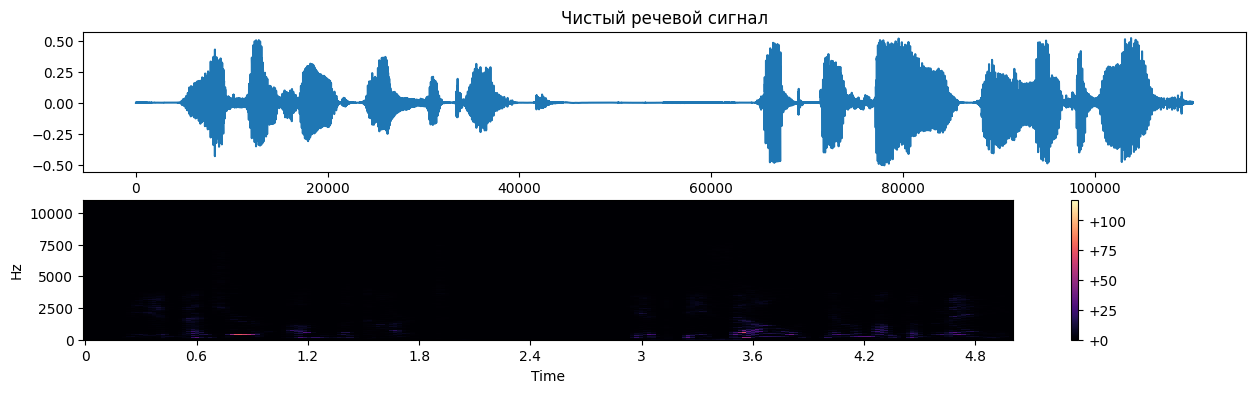

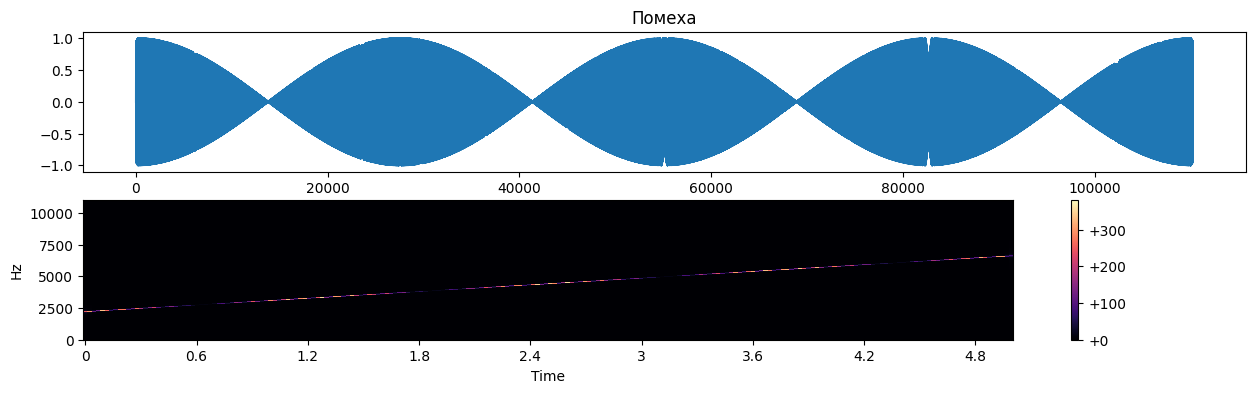

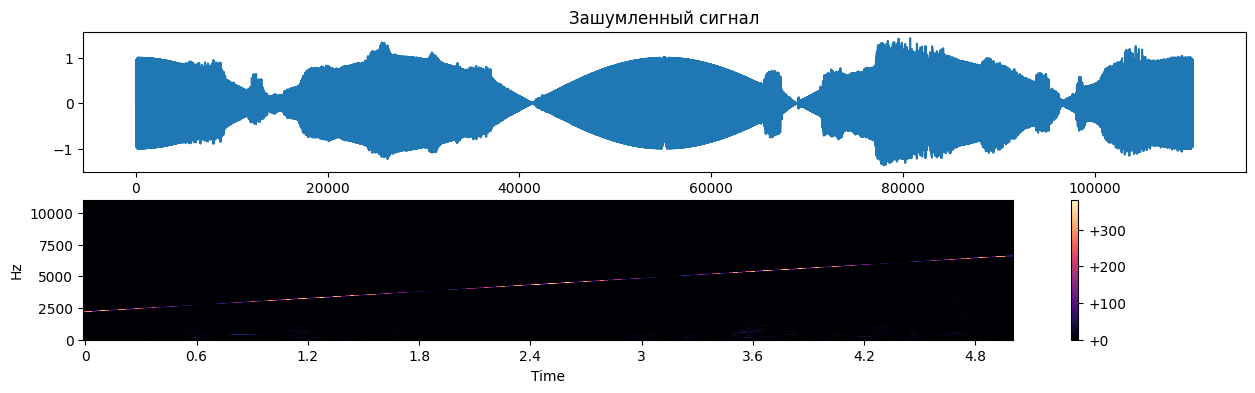

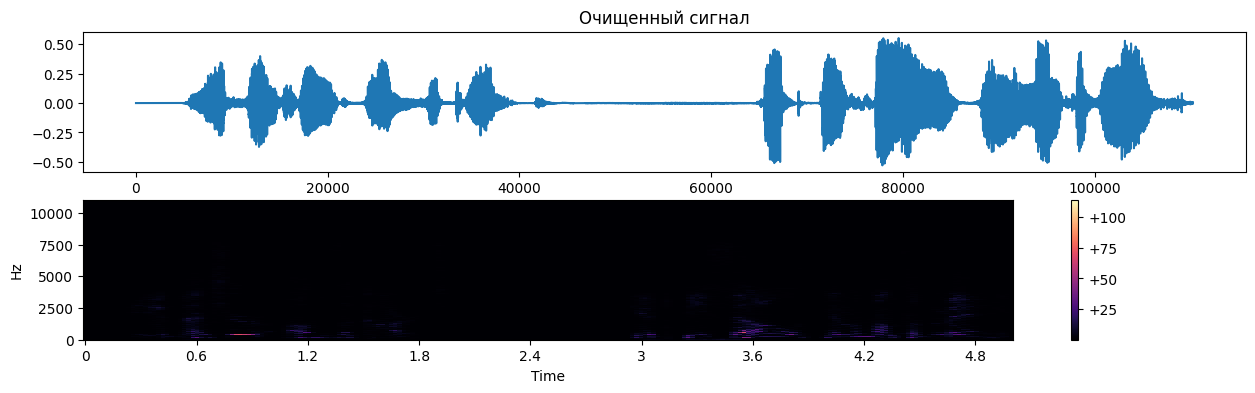

In [ ]:
# Визуализация и спектры чистого, зашумленного и очищенного сигнала, помех
def plot_signal_and_spectrum(signal, title, sr):
    plt.figure(figsize=(15, 4)) # инициализируем полотно
    plt.subplot(2, 1, 1) # делим полотно на 2 строки 1 столбец берем первый
    plt.plot(signal) # Рисуем сигнал
    plt.title(title) # Подписываем случай
    plt.subplot(2, 1, 2) # делим полотно на 2 строки 1 столбец берем второй
    D_compl=librosa.stft(signal) # Вычисляем коротковременное преобразование Фурье для сигнала
    D=np.abs(D_compl)# Получаем амплитуду комплексного спектра
    librosa.display.specshow(D, x_axis='time',y_axis='linear') # Отображаем спектрограмму с осью времени по горизонтали и линейной частотой по вертикали
    plt.colorbar(format='%+2.0f') # Выведем цветовую шкалу
    plt.show() # Вывод полотна

# График и спектр чистого сигнала
plot_signal_and_spectrum(speech, "Чистый речевой сигнал", sr)
# График и спектр помехи
plot_signal_and_spectrum(noise, "Помеха", sr)
# График и спектр зашумленного сигнала
plot_signal_and_spectrum(noisy_signal, "Зашумленный сигнал", sr)
# График и спектр очищенного сигнала
plot_signal_and_spectrum(filtered_signal, "Очищенный сигнал", sr)

In [ ]:
# Функция для визуализации изменения весов NLMS фильтра
def plot_weight(speech, noisy_signal, filter_len=10, lr=0.1):
    weights_history = []  # Список для хранения истории весов фильтра
    nlms_filter = NormalizedLMSFilter(lr, filter_len) # создаем фильтр
    filtered_signal = np.zeros_like(noisy_signal) # инициализируем сигнал той же размерности, что и защумленный

    for i in range(filter_len, len(noisy_signal)): # Для выполнения фильтрации требуется как минимум выборка filter_len
        x = noisy_signal[i-filter_len:i]  # Входные данные
        filtered_signal[i] = nlms_filter.predict(x) # Выходные данные
        nlms_filter.fit(x, speech[i])  # Обновление фильтра
        weights_history.append(nlms_filter.w.copy())  # Сохраняем текущее состояние весов фильтра

    weights_history = np.array(weights_history)  # Преобразуем историю весов в массив NumPy для удобства

    # График изменения коэффициентов фильтра во времени.
    plt.figure(figsize=(12, 6))  # Задаем размер полотна
    for i in range(filter_len):
        plt.plot(weights_history[:, i], label=f'Коэффициент {i+1}')  # Отображаем каждый коэффициент на графике
    plt.title("Изменение коэффициентов фильтра во времени")  # Заголовок графика
    plt.xlabel("Итерации")  # Подпись оси OX
    plt.ylabel("Значение коэффициента")  # Подпись оси OY
    plt.legend(loc='upper right', ncol=2)  # Добавляем легенду
    plt.show()  # Отображаем график

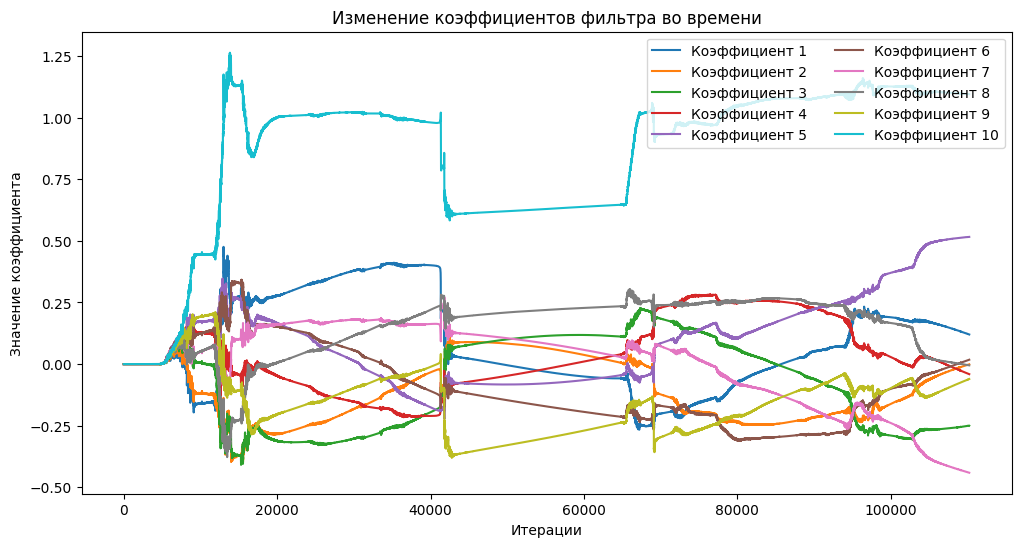

In [ ]:
plot_weight(speech, noisy_signal, filter_len=10, lr=0.1)

6. Также воспроизводите все графики в виде звука (можно нормализовать значения).

In [ ]:
ipd.Audio(speech, rate=sr)  # Прослушивание исходного сигнала

In [ ]:
ipd.Audio(noise, rate=sr)

In [ ]:
ipd.Audio(noisy_signal, rate=sr)  # Зашумленый сигнал

In [ ]:
ipd.Audio(filtered_signal, rate=sr)  # Очищенный сигнал

In [ ]:
ipd.Audio(broken_filtered_signal, rate=sr) # Эксперимент со сломанными параметрами

Для сравнения резульатов воспользуемся реализацией NLMS фильтра из padasip

In [ ]:
!pip install padasip

  Preparing metadata (setup.py) ... done
  Created wheel for padasip: filename=padasip-1.2.2-py3-none-any.whl size=51651 sha256=46145e0844ce81a5e6a5371a445ba2b58e60417cad26b4463d2ee523309fb7de
  Stored in directory: /root/.cache/pip/wheels/a0/bb/e7/b57f417dbad7d85dbcb177f2c185543ca34a1b36541f115e95
Successfully built padasip


In [ ]:
import padasip as pa # адаптивные фильтры

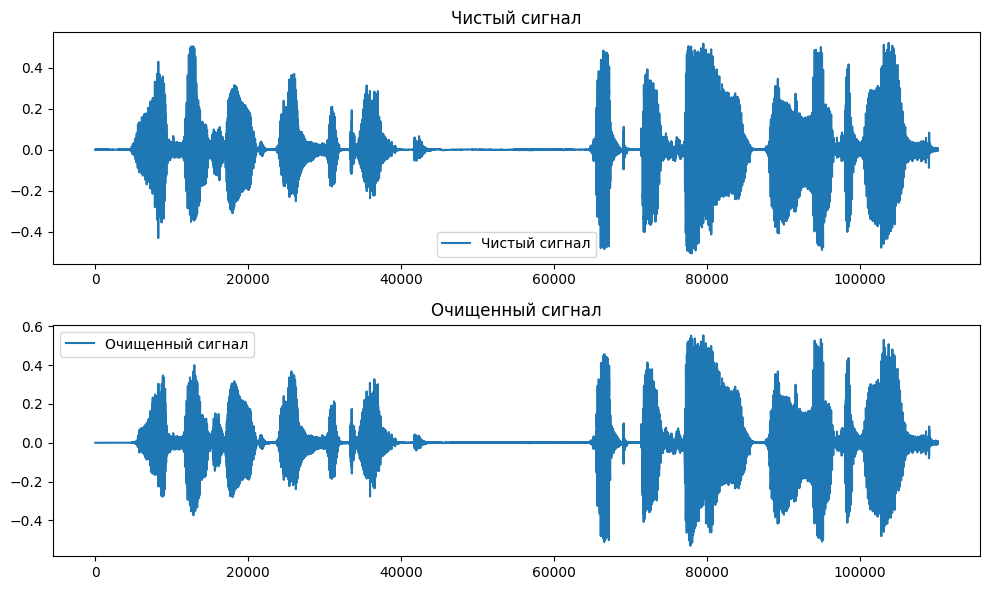

In [ ]:
# Подготовка данных для NLMS фильтра
filter_len = 20  # Длина фильтра
X = pa.input_from_history(noisy_signal, filter_len)  # Создание матрицы входных данных

# Инициализация NLMS фильтра
nlms_filter = pa.filters.FilterNLMS(n=filter_len, mu=0.01, w = 'zeros')  # mu - шаг обучения наш lr

# Применение NLMS фильтра
target_speech = speech[filter_len - 1 :] # Обрезаем чистый сигнал speech, чтобы он соответствовал длине X
filtered_signal_1, e, w = nlms_filter.run(target_speech, X) # Применение NLMS фильтра
# Применение NLMS фильтра
plt.figure(figsize=(10, 6)) # Задаем размер полотна

# График чистого сигнала
plt.subplot(2, 1, 1)
plt.plot(speech, label="Чистый сигнал")
plt.title("Чистый сигнал")
plt.legend()

# График очищенного сигнала
plt.subplot(2, 1, 2)
plt.plot(filtered_signal, label="Очищенный сигнал")
plt.title("Очищенный сигнал")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
ipd.Audio(filtered_signal_1, rate=sr) # Очищенный сигнал padasip

In [ ]:
ipd.Audio(speech, rate=sr) # Исходный сигнал